# Realistic Multi-Lead ECG Plot in Python

This notebook shows how to plot a **multi-lead ECG** with realistic ECG-paper style:

- Continuous red/black grid
- Amplitude and time calibration (10 mm/mV, 25 mm/s)
- Stacked leads with proper spacing

---

References:

1. In Digits: "ECG Analysis in Python" – https://www.indigits.com/post/2022/10/ecg_python/
2. Matplotlib grids and plotting: https://matplotlib.org/stable/gallery/ticks_and_spines/tick-locators.html
3. ECG calibration / paper standards: https://litfl.com/ecg-library/#standard

# Step 1: Import packages and set working directory

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sm

# --- User settings ---
ECG_FILE = "ECGu.txt"
OUTPUT_FILE = "ecg_strip.png"
fs = 360                # Sampling frequency in Hz
use_seconds = 10        # Duration to plot
lead_spacing_mV = 2.0   # Vertical spacing between leads (mV)
target_amplitude_mV = 1.0  # Typical amplitude scaling if units are arbitrary
# ----------------------

## Step 2: Load ECG data

We read the ECG from a text file. Multi-lead ECGs usually have columns representing each lead.  
We reshape if there is only one lead to maintain consistency.

In [19]:
import os
os.chdir('C:\\Users\\axour\\OneDrive\\Documents\\Courses\\IEAP\\Python-R-Git\\Series01-Python')
data = np.loadtxt(ECG_FILE)


print(data[:10])   # check first 10 samples

[[-275. -119. -119.]
 [-275. -119. -119.]
 [-275. -118. -121.]
 [-275. -121. -112.]
 [-273. -120. -105.]
 [-274. -124. -101.]
 [-274. -126.  -86.]
 [-273. -126.  -73.]
 [-270. -125.  -70.]
 [-274. -120.  -80.]]


### Step 3 : ECG Paper Grid Calibration
- `time_per_small = 0.04`  
  Each small horizontal box on ECG paper represents 0.04 seconds (25 mm/s speed standard).
- `time_per_large = 0.20`  
  Each large horizontal box (5 small boxes) represents 0.2 seconds.
- `amp_per_small = 0.1`  
  Each small vertical box represents 0.1 mV (10 mm/mV standard).
- `amp_per_large = 0.5`  
  Each large vertical box (5 small boxes) represents 0.5 mV.


In [21]:
# ECG paper grid calibration
time_per_small = 0.04     # 1 small box = 0.04 s (25 mm/s)
time_per_large = 0.20     # 1 large box = 0.2 s
amp_per_small = 0.1       # 1 small box = 0.1 mV
amp_per_large = 0.5       # 1 large box = 0.5 mV

4. **Extraction du segment** : On sélectionne les premiers `n_samples` correspondant à la durée souhaitée (`use_seconds`). Si l’ECG est plus court, on complète avec des zéros. L’axe temps `ts` est créé en secondes.

5. **Gain automatique** : Le signal est normalisé pour que son amplitude maximale corresponde à `target_amplitude_mV` (~1 mV), afin que le tracé s’intègre correctement sur la grille ECG.

6. **Tracé des leads** : Chaque lead est empilé verticalement avec un offset constant (`lead_spacing_mV`) pour éviter la superposition. Les signaux sont tracés en noir.

7. **Grille ECG** : 
   - Verticale : lignes majeures rouges tous les 0.2 s, lignes mineures noires tous les 0.04 s  
   - Horizontale : lignes majeures rouges tous les 0.5 mV, lignes mineures noires tous les 0.1 mV  
   - Limites des axes ajustées pour inclure tous les leads avec marge.

8. **Nettoyage du tracé** : On supprime les labels, ticks et spines pour un rendu identique à une feuille ECG papier.

9. **Export** : Le graphique est sauvegardé en PNG haute résolution (`dpi=300`) pour impression ou rapport.

Applying gain factor: 0.00
✅ Realistic ECG strip saved as ecg_strip.png


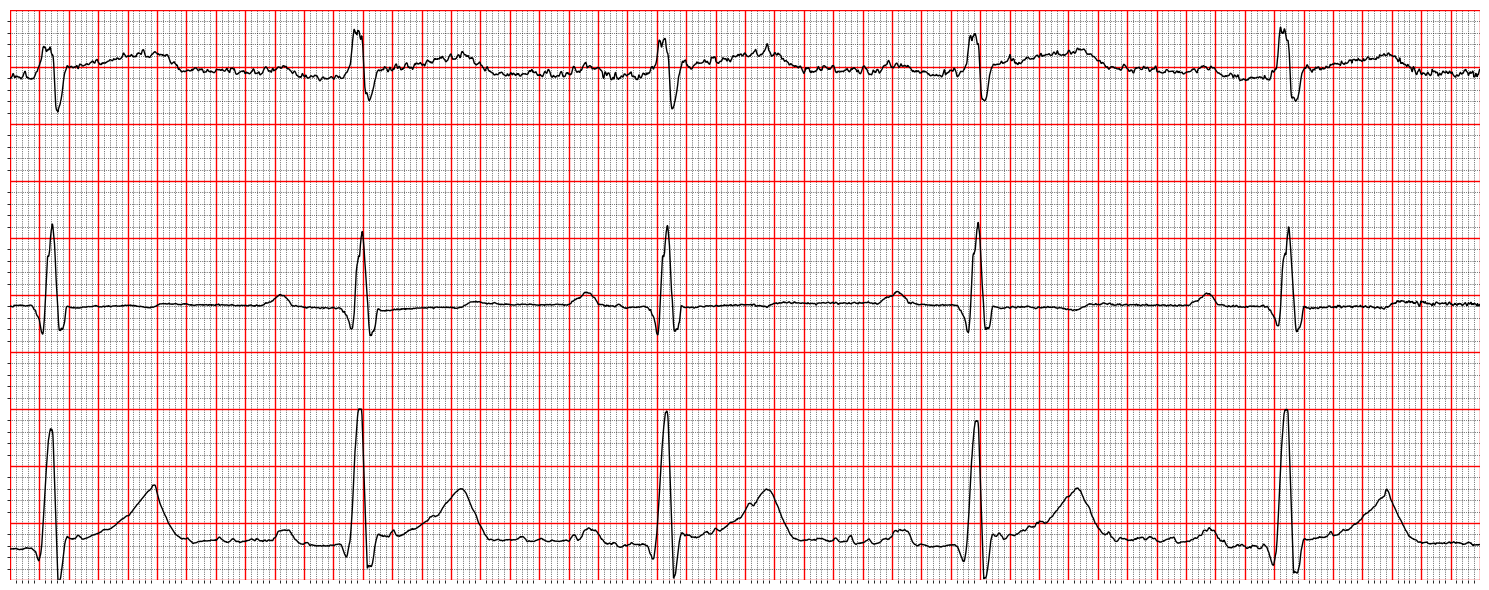

In [37]:
# --- Extract segment ---
n_samples = int(fs * use_seconds)
if data.shape[0] < n_samples:
    seg = np.zeros((n_samples, data.shape[1]))
    seg[:data.shape[0], :] = data
else:
    seg = data[:n_samples, :]
ts = np.arange(seg.shape[0]) / fs

# --- Gain scaling to approximate mV ---
max_amp = np.max(np.abs(seg))
gain = target_amplitude_mV / max_amp
print(f"Applying gain factor: {gain:.2f}")

# --- Plot ECG ---
fig, ax = plt.subplots(figsize=(15, 6))
n_leads = seg.shape[1]

for i in range(n_leads):
    offset = i * lead_spacing_mV
    ax.plot(ts, seg[:, i]*gain + offset, color="black", linewidth=1)

# --- Configure ECG paper grid ---
ymin = -amp_per_large
ymax = (n_leads-1)*lead_spacing_mV + amp_per_large
ax.set_xlim([ts[0], ts[-1]])
ax.set_ylim([ymin, ymax])

# Vertical grid lines
ax.set_xticks(np.arange(0, ts[-1]+time_per_large, time_per_large))
ax.set_xticks(np.arange(0, ts[-1]+time_per_small, time_per_small), minor=True)

# Horizontal grid lines
ax.set_yticks(np.arange(ymin, ymax+amp_per_large, amp_per_large))
ax.set_yticks(np.arange(ymin, ymax+amp_per_small, amp_per_small), minor=True)

ax.grid(which='major', linestyle='-', color='red', linewidth=1.0)
ax.grid(which='minor', linestyle=':', color='black', linewidth=0.5)

# Hide ticks, labels, spines
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
print(f"✅ Realistic ECG strip saved as {OUTPUT_FILE}")